<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN_LSTM/CNN_LSTM_Corn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 5.27 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 21 15:14:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Corn'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN_LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len, time_distributed=True)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 7.3 MB/s 
     |████████████████████████████████| 170 kB 36.5 MB/s 
     |████████████████████████████████| 97 kB 8.4 MB/s 
     |████████████████████████████████| 138 kB 55.2 MB/s 
     |████████████████████████████████| 133 kB 22.9 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [13]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [14]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=config.activation), input_shape=(None, window_len, 1)))
    # layer 2
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    # layer 3
    model.add(TimeDistributed(Flatten()))
    # layer 4
    model.add(LSTM(units=128, activation='tanh', return_sequences=False))
    # layer 5
    model.add(Dropout(0.1))
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [15]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: pf9ip4m8
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN_LSTM/sweeps/pf9ip4m8


In [ ]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: uj86qris with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
31/31 [==============================] - 40s 43ms/step - loss: 0.1189 - mean_squared_error: 0.1189 - mean_absolute_error: 0.2955 - val_loss: 0.1120 - val_mean_squared_error: 0.1120 - val_mean_absolute_error: 0.2781
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0401 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1361 - val_loss: 0.0623 - val_mean_squared_error: 0.0623 - val_mean_absolute_error: 0.2036
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - mean_absolute_error: 0.0977 - val_loss: 0.0532 - val_mean_squared_error: 0.0532 - val_mean_absolute_error: 0.1865
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - mean_absolute_error: 0.1049 - val_loss: 0.0506 - val_mean_squared_error: 0.0506 - val_mean_absolute_error: 0.1815
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0187 - mean_squared_error: 0

epoch,49
loss,0.00685
mean_squared_error,0.00685
mean_absolute_error,0.06006
val_loss,0.03497
val_mean_squared_error,0.03497
val_mean_absolute_error,0.15181
_runtime,61
_timestamp,1626876388
_step,49
best_val_loss,0.03497


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: yznv0ape with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 4s 164ms/step - loss: 0.1548 - mean_squared_error: 0.1548 - mean_absolute_error: 0.3509 - val_loss: 0.2587 - val_mean_squared_error: 0.2587 - val_mean_absolute_error: 0.4511
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.1449 - mean_squared_error: 0.1449 - mean_absolute_error: 0.3329 - val_loss: 0.2292 - val_mean_squared_error: 0.2292 - val_mean_absolute_error: 0.4197
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.1212 - mean_squared_error: 0.1212 - mean_absolute_error: 0.2971 - val_loss: 0.1994 - val_mean_squared_error: 0.1994 - val_mean_absolute_error: 0.3858
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.1015 - mean_squared_error: 0.1015 - mean_absolute_error: 0.2633 - val_loss: 0.1726 - val_mean_squared_error: 0.1726 - val_mean_absolute_error: 0.3542
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0813 - mean_squared_error: 0.0813 -

epoch,49
loss,0.01886
mean_squared_error,0.01886
mean_absolute_error,0.09977
val_loss,0.04881
val_mean_squared_error,0.04881
val_mean_absolute_error,0.17888
_runtime,15
_timestamp,1626876424
_step,49
best_val_loss,0.04881


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▅▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▇▆▅▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 04my2d6y with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 4s 85ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1415 - val_loss: 0.0384 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1640
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0611 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1514
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0600 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1311
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0578 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1287
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_erro

epoch,89
loss,0.00181
mean_squared_error,0.00181
mean_absolute_error,0.03191
val_loss,0.00991
val_mean_squared_error,0.00991
val_mean_absolute_error,0.07439
_runtime,23
_timestamp,1626876462
_step,89
best_val_loss,0.00963


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▄▂▂▃▂▂▂▂▁▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▇▇▃▆▃▂▂▆▂▂▂▂▂▂▂▃▁▁▂▁▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▇▇▃▆▃▂▂▆▂▂▂▂▂▂▂▃▁▁▂▁▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▇▇▃▇▄▃▂▆▂▂▂▂▂▂▃▄▂▁▂▁▁▁▁▁▂▁▂▃▁▁▂▁▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: dqwocy0g with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 4s 35ms/step - loss: 0.0293 - mean_squared_error: 0.0293 - mean_absolute_error: 0.1087 - val_loss: 0.0352 - val_mean_squared_error: 0.0352 - val_mean_absolute_error: 0.1568
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0735 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1193
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0575 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1310
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0560 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1125
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0050 - mean_squared_erro

epoch,35
loss,0.00188
mean_squared_error,0.00188
mean_absolute_error,0.03236
val_loss,0.01008
val_mean_squared_error,0.01008
val_mean_absolute_error,0.07485
_runtime,17
_timestamp,1626876494
_step,35
best_val_loss,0.00997


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▄▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁
val_loss,█▄▆▄▃▃▃▂▃▃▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▄▁▂▁▂▃▁▁
val_mean_squared_error,█▄▆▄▃▃▃▂▃▃▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▄▁▂▁▂▃▁▁
val_mean_absolute_error,█▅▆▄▃▃▃▃▄▃▂▂▂▂▃▃▂▂▂▁▁▂▂▁▁▁▁▁▅▁▂▁▂▃▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 311s96mm with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 4s 139ms/step - loss: 0.0779 - mean_squared_error: 0.0779 - mean_absolute_error: 0.2142 - val_loss: 0.0370 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1532
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0761 - val_loss: 0.0436 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1785
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0676 - val_loss: 0.0332 - val_mean_squared_error: 0.0332 - val_mean_absolute_error: 0.1424
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0695 - val_loss: 0.0315 - val_mean_squared_error: 0.0315 - val_mean_absolute_error: 0.1487
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0068 - mean_squared_error: 0.0

epoch,99
loss,0.00146
mean_squared_error,0.00146
mean_absolute_error,0.02855
val_loss,0.01038
val_mean_squared_error,0.01038
val_mean_absolute_error,0.07605
_runtime,22
_timestamp,1626876527
_step,99
best_val_loss,0.00979


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: tel1v6kn with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 4s 142ms/step - loss: 0.0614 - mean_squared_error: 0.0614 - mean_absolute_error: 0.1638 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1483
Epoch 2/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0599 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1367
Epoch 3/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0527 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1426
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0869 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1238
Epoch 5/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0052 - mean_squared_error: 0.

epoch,95
loss,0.00149
mean_squared_error,0.00149
mean_absolute_error,0.02917
val_loss,0.01145
val_mean_squared_error,0.01145
val_mean_absolute_error,0.0828
_runtime,22
_timestamp,1626876565
_step,95
best_val_loss,0.00971


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▃▂▂▂▂▂▂▁▂▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▅▃▃▃▃▂▂▃▂▂▂▂▂▂▁▁▁▁▁▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▅▃▃▃▃▂▂▃▂▂▂▂▂▂▁▁▁▁▁▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▇█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▃▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: nwxmwmdp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
16/16 [==============================] - 4s 70ms/step - loss: 0.1364 - mean_squared_error: 0.1364 - mean_absolute_error: 0.3258 - val_loss: 0.1888 - val_mean_squared_error: 0.1888 - val_mean_absolute_error: 0.3734
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0782 - mean_squared_error: 0.0782 - mean_absolute_error: 0.2232 - val_loss: 0.1085 - val_mean_squared_error: 0.1085 - val_mean_absolute_error: 0.2734
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0378 - mean_squared_error: 0.0378 - mean_absolute_error: 0.1319 - val_loss: 0.0729 - val_mean_squared_error: 0.0729 - val_mean_absolute_error: 0.2217
Epoch 4/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0244 - mean_squared_error: 0.0244 - mean_absolute_error: 0.1006 - val_loss: 0.0594 - val_mean_squared_error: 0.0594 - val_mean_absolute_error: 0.1988
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0210 - mean_squared_err

epoch,199
loss,0.00542
mean_squared_error,0.00542
mean_absolute_error,0.0541
val_loss,0.02995
val_mean_squared_error,0.02995
val_mean_absolute_error,0.14126
_runtime,48
_timestamp,1626876624
_step,199
best_val_loss,0.02995


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: i5gg4l00 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 4s 40ms/step - loss: 0.3366 - mean_squared_error: 0.3366 - mean_absolute_error: 0.3643 - val_loss: 0.0317 - val_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.1478
Epoch 2/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0587 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1087
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0433 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0998
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0399 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0945
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0

epoch,46
loss,0.00142
mean_squared_error,0.00142
mean_absolute_error,0.02811
val_loss,0.00971
val_mean_squared_error,0.00971
val_mean_absolute_error,0.07212
_runtime,23
_timestamp,1626876658
_step,46
best_val_loss,0.00925


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▁▁▂▁▁▁▁▂▂▂▂▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▁▁▂▁▁▁▁▂▂▂▂▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▂▂▃▂▂▂▂▂▂▁▁▁▂▂▂▂▂▁▁▂▂▁▁▂▂▁▁▁▁▂▁▁▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: oxya706x with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 4s 37ms/step - loss: 0.0399 - mean_squared_error: 0.0399 - mean_absolute_error: 0.1200 - val_loss: 0.0434 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1563
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0629 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1249
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0568 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1198
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0458 - val_loss: 0.0383 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1577
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0061 - mean_squared_erro

epoch,64
loss,0.00154
mean_squared_error,0.00154
mean_absolute_error,0.02956
val_loss,0.01087
val_mean_squared_error,0.01087
val_mean_absolute_error,0.07837
_runtime,25
_timestamp,1626876696
_step,64
best_val_loss,0.00958


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▇▃▃▂▂▂▂▃▂▂▃▂▁▂▂▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▇▃▃▂▂▂▂▃▂▂▃▂▁▂▂▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅█▄▄▃▃▃▃▄▂▂▄▂▂▃▂▂▁▂▂▃▂▁▁▂▃▁▁▂▂▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: eymcvda9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 3s 139ms/step - loss: 0.1401 - mean_squared_error: 0.1401 - mean_absolute_error: 0.3286 - val_loss: 0.1497 - val_mean_squared_error: 0.1497 - val_mean_absolute_error: 0.3250
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0502 - mean_squared_error: 0.0502 - mean_absolute_error: 0.1591 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.2025
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - mean_absolute_error: 0.1112 - val_loss: 0.0465 - val_mean_squared_error: 0.0465 - val_mean_absolute_error: 0.1695
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0265 - mean_squared_error: 0.0265 - mean_absolute_error: 0.1388 - val_loss: 0.0456 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1677
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0248 - mean_squared_error: 0.0248 -

epoch,49
loss,0.0066
mean_squared_error,0.0066
mean_absolute_error,0.05949
val_loss,0.03487
val_mean_squared_error,0.03487
val_mean_absolute_error,0.15102
_runtime,16
_timestamp,1626876744
_step,49
best_val_loss,0.03487


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: bp14vjsm with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 3s 129ms/step - loss: 0.0900 - mean_squared_error: 0.0900 - mean_absolute_error: 0.2369 - val_loss: 0.0552 - val_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.1963
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - mean_absolute_error: 0.0999 - val_loss: 0.0323 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1470
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0686 - val_loss: 0.0325 - val_mean_squared_error: 0.0325 - val_mean_absolute_error: 0.1456
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0617 - val_loss: 0.0302 - val_mean_squared_error: 0.0302 - val_mean_absolute_error: 0.1414
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0059 - mean_squared_error: 0.00

epoch,99
loss,0.00154
mean_squared_error,0.00154
mean_absolute_error,0.03024
val_loss,0.01087
val_mean_squared_error,0.01087
val_mean_absolute_error,0.07799
_runtime,22
_timestamp,1626876781
_step,99
best_val_loss,0.01031


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: mucjgtt8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 4s 70ms/step - loss: 0.0575 - mean_squared_error: 0.0575 - mean_absolute_error: 0.1780 - val_loss: 0.0540 - val_mean_squared_error: 0.0540 - val_mean_absolute_error: 0.2003
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0817 - val_loss: 0.0354 - val_mean_squared_error: 0.0354 - val_mean_absolute_error: 0.1588
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0674 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1355
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0523 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1291
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0042 - mean_squared_e

epoch,74
loss,0.00157
mean_squared_error,0.00157
mean_absolute_error,0.02939
val_loss,0.00964
val_mean_squared_error,0.00964
val_mean_absolute_error,0.07436
_runtime,25
_timestamp,1626876818
_step,74
best_val_loss,0.00963


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 84r6aj2j with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 4s 37ms/step - loss: 0.1199 - mean_squared_error: 0.1199 - mean_absolute_error: 0.2976 - val_loss: 0.1032 - val_mean_squared_error: 0.1032 - val_mean_absolute_error: 0.2709
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.1278 - val_loss: 0.0532 - val_mean_squared_error: 0.0532 - val_mean_absolute_error: 0.1927
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - mean_absolute_error: 0.0900 - val_loss: 0.0432 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1713
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0892 - val_loss: 0.0414 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1673
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0130 - mean_squared_erro

epoch,99
loss,0.00493
mean_squared_error,0.00493
mean_absolute_error,0.05247
val_loss,0.02722
val_mean_squared_error,0.02722
val_mean_absolute_error,0.13682
_runtime,39
_timestamp,1626876871
_step,99
best_val_loss,0.02722


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3gu44ydk with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 4s 37ms/step - loss: 0.3855 - mean_squared_error: 0.3855 - mean_absolute_error: 0.2988 - val_loss: 0.0478 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1637
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0915 - val_loss: 0.0690 - val_mean_squared_error: 0.0690 - val_mean_absolute_error: 0.2114
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0925 - val_loss: 0.0527 - val_mean_squared_error: 0.0527 - val_mean_absolute_error: 0.1868
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0750 - val_loss: 0.0436 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1679
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0091 - mean_squared_erro

epoch,15
loss,0.00346
mean_squared_error,0.00346
mean_absolute_error,0.04374
val_loss,0.04608
val_mean_squared_error,0.04608
val_mean_absolute_error,0.1746
_runtime,13
_timestamp,1626876897
_step,15
best_val_loss,0.01624


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁
val_loss,▅█▆▅▁▁▂▁▃▂▂▁▁▁▁▅
val_mean_squared_error,▅█▆▅▁▁▂▁▃▂▂▁▁▁▁▅
val_mean_absolute_error,▅█▆▅▁▁▂▁▄▂▂▁▁▂▁▆
_runtime,▁▁▃▃▃▅▅▅▅▆▆▆▆███
_timestamp,▁▁▃▃▃▅▅▅▅▆▆▆▆███
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Agent Starting Run: v4588vqk with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 4s 130ms/step - loss: 2.6659 - mean_squared_error: 2.6659 - mean_absolute_error: 1.0863 - val_loss: 0.1335 - val_mean_squared_error: 0.1335 - val_mean_absolute_error: 0.3021
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0442 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1352 - val_loss: 0.0461 - val_mean_squared_error: 0.0461 - val_mean_absolute_error: 0.1759
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0830 - val_loss: 0.0376 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1594
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0664 - val_loss: 0.0346 - val_mean_squared_error: 0.0346 - val_mean_absolute_error: 0.1554
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0291 - mean_squared_error: 0.0291 - m

epoch,49
loss,0.00405
mean_squared_error,0.00405
mean_absolute_error,0.04982
val_loss,0.01526
val_mean_squared_error,0.01526
val_mean_absolute_error,0.09821
_runtime,14
_timestamp,1626876924
_step,49
best_val_loss,0.01349


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: choybjl8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 4s 68ms/step - loss: 0.0557 - mean_squared_error: 0.0557 - mean_absolute_error: 0.1809 - val_loss: 0.0370 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1482
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0905 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1375
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0609 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1311
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0516 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1208
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_err

epoch,70
loss,0.00148
mean_squared_error,0.00148
mean_absolute_error,0.02878
val_loss,0.00994
val_mean_squared_error,0.00994
val_mean_absolute_error,0.07611
_runtime,24
_timestamp,1626876965
_step,70
best_val_loss,0.0093


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▅▄▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: l708dbsg with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 4s 69ms/step - loss: 0.1337 - mean_squared_error: 0.1337 - mean_absolute_error: 0.2330 - val_loss: 0.0381 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1644
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0731 - val_loss: 0.0479 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1692
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0770 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - val_mean_absolute_error: 0.1765
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0675 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1303
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0072 - mean_squared_er

epoch,46
loss,0.00219
mean_squared_error,0.00219
mean_absolute_error,0.03578
val_loss,0.0135
val_mean_squared_error,0.0135
val_mean_absolute_error,0.09051
_runtime,20
_timestamp,1626877000
_step,46
best_val_loss,0.00984


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▄▃▂▂▂▃▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▇▇▄▃▃█▂▄▂▄▅▂▂▁▅▃▂▁▂▁▂▁▁▁▁▁▂▁▃▁▁▁▁▂▁▃▃▁▂
val_mean_squared_error,▆▇▇▄▃▃█▂▄▂▄▅▂▂▁▅▃▂▁▂▁▂▁▁▁▁▁▂▁▃▁▁▁▁▂▁▃▃▁▂
val_mean_absolute_error,▇▇█▅▄▄█▃▅▂▅▆▃▃▂▅▄▂▁▂▁▃▁▁▁▂▁▂▁▃▁▁▂▂▂▁▄▄▁▂
_runtime,▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: bho25u7p with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 4s 39ms/step - loss: 0.0449 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1569 - val_loss: 0.0361 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1531
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0609 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1401
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0531 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1285
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0474 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1186
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0032 - mean_squared_err

epoch,49
loss,0.00143
mean_squared_error,0.00143
mean_absolute_error,0.02815
val_loss,0.00956
val_mean_squared_error,0.00956
val_mean_absolute_error,0.07347
_runtime,24
_timestamp,1626877037
_step,49
best_val_loss,0.00928


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▃▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: wbcwuwvs with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 4s 145ms/step - loss: 0.3495 - mean_squared_error: 0.3495 - mean_absolute_error: 0.4721 - val_loss: 0.1681 - val_mean_squared_error: 0.1681 - val_mean_absolute_error: 0.3352
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0691 - mean_squared_error: 0.0691 - mean_absolute_error: 0.1727 - val_loss: 0.1108 - val_mean_squared_error: 0.1108 - val_mean_absolute_error: 0.2564
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0489 - mean_squared_error: 0.0489 - mean_absolute_error: 0.1331 - val_loss: 0.0427 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1642
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - mean_absolute_error: 0.1274 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1505
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0122 - mean_squared_error: 0.

# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [12]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'learning_rate': 0.0005,
    'optimizer': 'adam',
    'activation': 'relu'
}

In [13]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=best_config['activation']), input_shape=(None, window_len, 1)))
# layer 2
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# layer 3
model.add(TimeDistributed(Flatten()))
# layer 4
model.add(LSTM(units=128, activation='tanh', return_sequences=False))
# layer 5
model.add(Dropout(0.1))
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  984065


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 29, 128)     384       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 14, 128)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1792)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               983552    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 984,065
Trainable params: 984,065
Non-trainable params: 0
__________________________________________________

In [15]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
39/39 [==============================] - 35s 4ms/step - loss: 0.0441
Epoch 2/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0068
Epoch 3/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 4/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 5/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 6/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 7/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 8/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 9/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 10/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 11/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 12/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 13/100
39/39 [================

In [16]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

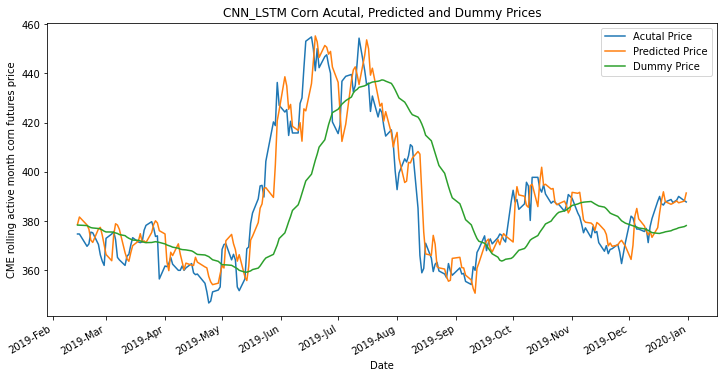

In [17]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

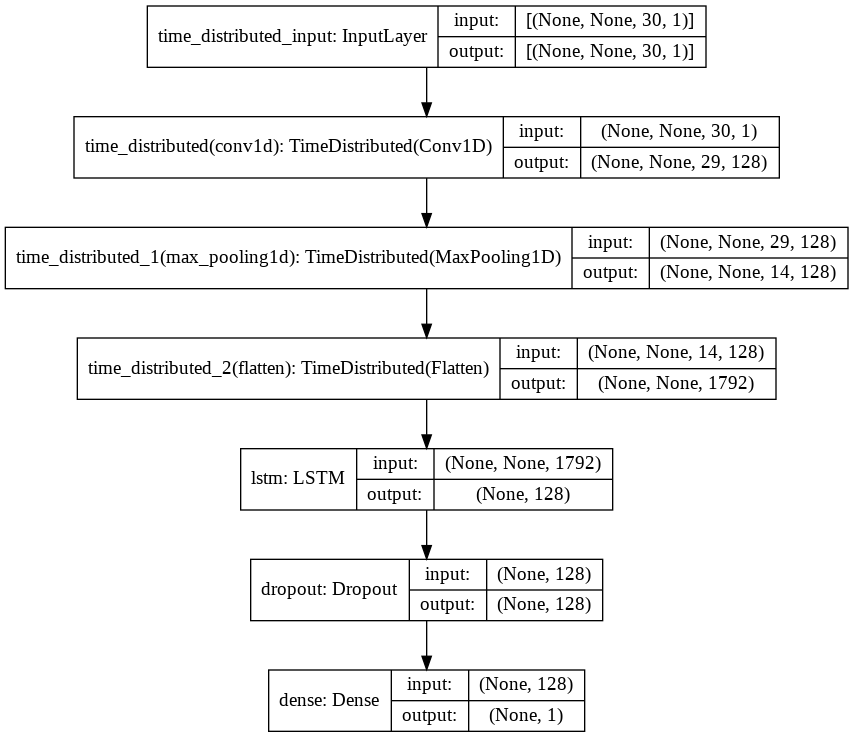

In [18]:
plot_model(model, show_shapes=True, expand_nested=True)

In [19]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.007592858378521029
RMSE:  0.08713700923557699
MAE:  0.06427847411362955
Dummy MSE:  0.041446864361575214
Dummy RMSE:  0.20358502980714277
Dummy MAE:  0.15160472972972977


In [20]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_LSTM_Corn/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_LSTM_Corn/assets
